In [3]:
import numpy as np
from scipy.sparse import (csr_matrix, csr_matrix, coo_matrix,
                bsr_matrix, dia_matrix, dok_matrix, lil_matrix)
from numpy.random import rand
from time import time
import random

n = 10000 # dimension of matrix

# List of Lists format (lil_matrix)

Create a list of list matrix that is of size n x n.  We will fill that one with random values.  Also create lil matrix that is identity.

In [27]:
lil1 = lil_matrix((n,n))
lilIdentity = lil_matrix((n,n))

Fill the first one hundred values of the zeroth row with random numbers over the distribution [0, 1).  Then fill the diagonal also with random numbers.

In [28]:
lil1[0, :100] = rand(100)
lil1.setdiag(rand(n))


Fill in the identity matrix.

In [29]:
for i in range(n):
    lilIdentity[i,i] = 1

See how long it takes to multiply a lil matrix with another lil matrix.

In [30]:
time1 = time()
lil1 = lil1*lilIdentity
print("Time(s) for lil multiply: " + str(time() - time1))

Time(s) for lil multiply: 0.004141092300415039


Convert them to dense matrices and see how long the multiply takes.

In [6]:
dense1 = lil1.toarray()
denseIdentity = lilIdentity.toarray()
time1 = time()
dense1 = dense1 * denseIdentity
print("Time(s) for dense multiple: " + str(time() - time1))

Time(s) for dense multiple: 0.799267053604126


Now how does adding matrices compare?

In [7]:
lil2 = lil1
time1 = time()
lil2 = lil2 + lil2
print("Time(s) for lil add: " + str(time() - time1))

Time(s) for lil add: 0.0014309883117675781


In [8]:
dense1 = lil1.toarray()
denseIdentity = lilIdentity.toarray()
time1 = time()
dense1 = dense1 + dense1
print("Time(s) for dense add: " + str(time() - time1))

Time(s) for dense add: 0.49991512298583984


What happens when a lil matrix has many values?

In [9]:
lilManyValues = lil_matrix((n,n))
numValues = int(n*n / 10)
for iter in range(numValues):
    i = random.randrange(n)
    j = random.randrange(n)
    lilManyValues[i,j] = 1
print("Fraction nonzero: " + str(lilManyValues.count_nonzero() / (n*n)))
    
time1 = time()
lilManyValues = lilManyValues * lilManyValues
print("Time for lil multiply: " + str(time() - time1))

denseManyValues = lilManyValues.toarray()
time1 = time()
denseManyValues = denseManyValues * denseManyValues
print("Time for dense multiply: " + str(time() - time1))

Fraction nonzero: 0.09515335
Time for lil multiply: 27.59840989112854
Time for dense multiply: 0.3948829174041748


# Compressed Sparse Row (csr_matrix) and Compressed Sparse Column (csc_matrix)

In [10]:
csr1 = lil1.tocsr()
csc1 = lil1.tocsc()
csrIdentity = lilIdentity.tocsr()
cscIdentity = lilIdentity.tocsc()

In [11]:
time1 = time()
csr1 = csr1*csr1
print("Time(s) for csr multiply: " + str(time() - time1))

Time(s) for csr multiply: 0.0010101795196533203


In [12]:
csr2 = csr1
time1 = time()
csr2 = csr2 + csr2
print("Time(s) for csr add: " + str(time() - time1))

Time(s) for csr add: 0.0008299350738525391


In [13]:
iters = 10000
time1 = time()
for i in range(iters):
    index = random.randrange(n)
    row = csr1[index,:]
    nnz = row.count_nonzero()
print("Time(s) for accessing rows: " + str(time() - time1))
for i in range(iters):
    index = random.randrange(n)
    row = csr1[:,index]
    nnz = row.count_nonzero()
print("Time(s) for accessing columns: " + str(time() - time1))


Time(s) for accessing rows: 0.8638899326324463
Time(s) for accessing columns: 2.2232260704040527


In [14]:
iters = 10000
time1 = time()
for i in range(iters):
    index = random.randrange(n)
    row = csc1[index,:]
    nnz = row.count_nonzero()
print("Time(s) for accessing rows: " + str(time() - time1))
for i in range(iters):
    index = random.randrange(n)
    row = csc1[:,index]
    nnz = row.count_nonzero()
print("Time(s) for accessing columns: " + str(time() - time1))

Time(s) for accessing rows: 1.3914291858673096
Time(s) for accessing columns: 2.2636029720306396


# Hindom Optimization Equation 

F(t+1)=(1/(1+mu)) D^(-1/2) M' D^(-1/2) F(t) + (mu/(1+mu)) Y

Create something that looks like M' of Hindom.

In [14]:
n = 200
M = lil_matrix((n,n))
numValues = 500
for iter in range(numValues):
    i = random.randrange(n)
    j = random.randrange(n)
    M[i,j] = random.random() # [0,1)
print("Fraction nonzero: " + str(M.count_nonzero() / (n*n)))
M = M.tocsr()

Fraction nonzero: 0.01245


Actually have to create an affinity matrix.

In [15]:
import sys
import math
import matplotlib.pyplot as plt

W = M.toarray()
x_values = []
y_values = []
time1 = time()
for i in range(n):
    for j in range(n):
        if i == j:
            W[i,j] = 0
        else:
            x = M[i,:].toarray() - M[j,:].toarray()
            x = np.linalg.norm(x, ord=2)
            y = math.exp(-pow(x,2))
            #y = math.exp(-x)
            x_values.append(x)
            y_values.append(y)
            W[i,j] = y
print("Time(s) for computing affinity: " + str(time() - time1))
M = W

Time(s) for computing affinity: 9.18849778175354


Here is a plot of the original normed values with the compute affinity (should look like half a gaussian).

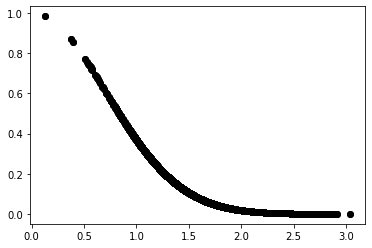

In [17]:
plt.plot(np.array(x_values), np.array(y_values), 'o', color='black');

Create diagonal matrix D

In [18]:
data = np.squeeze(np.asarray(M.sum(axis=1))) # sum the rows
offsets = np.array([0])
D = dia_matrix((data, offsets), shape=(n,n))

Calculate the exponent (-1/2), which is easy for a diagonal.  We can just take each diagonal element and raise it to (-1/2).

In [19]:
D = D.tocsr() # Convert to csr because can't use subscripting
for i in range(n):
    D[i,i] = D[i,i] ** (-1/2) 

Create the matrix S

In [20]:
S = D * M * D

mu is just how we weight each piece, smoothness vs fidelity to known labels

In [21]:
mu = 0.95
alpha = 1/(1 + mu)
beta = mu/(1 + mu)

Create some labels. 

In [22]:
Y = np.zeros((n,2))
# Set some to be malicious and benign
for i in range(int(n/10)):
    index = random.randrange(n)
    if i % 2 == 0:
        Y[index,0] = 1
        Y[index,1] = 0
    else:
        Y[index,0] = 0
        Y[index,1] = 1

Set F to be Y.

In [23]:
F = Y
print(F)

[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 0.]
 [0. 0.]
 [0. 0.]
 [1. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [1. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


Do one iteration

In [24]:
F = alpha * S.dot(F) + beta * Y
print(F)

[[0.00775376 0.01210722]
 [0.01713379 0.02353679]
 [0.02425186 0.02861791]
 [0.03847417 0.0491304 ]
 [0.02383899 0.02770945]
 [0.02114604 0.0168602 ]
 [0.01033918 0.00798937]
 [0.02404595 0.02363215]
 [0.03300134 0.0380312 ]
 [0.02314392 0.02253736]
 [0.0127022  0.01453765]
 [0.01792965 0.02424307]
 [0.00834603 0.00983918]
 [0.03578217 0.03199572]
 [0.03907055 0.04648056]
 [0.01510152 0.00689346]
 [0.01245247 0.02079395]
 [0.03218728 0.04612772]
 [0.01667312 0.02059033]
 [0.02336404 0.03622777]
 [0.50441184 0.02858314]
 [0.00980523 0.01030264]
 [0.02511681 0.03027172]
 [0.50096429 0.0193638 ]
 [0.02196329 0.02694405]
 [0.02420076 0.02254205]
 [0.0334739  0.03934599]
 [0.014278   0.01698592]
 [0.02696915 0.02596892]
 [0.02882555 0.03442641]
 [0.50130377 0.01128322]
 [0.02118739 0.02058973]
 [0.02424609 0.0275255 ]
 [0.0140921  0.01733037]
 [0.0316816  0.03537402]
 [0.03579978 0.04980864]
 [0.02198857 0.02494236]
 [0.02638029 0.03136452]
 [0.01188974 0.01414472]
 [0.01472305 0.02074468]


In [25]:
for i in range(10000):
  F = alpha * S.dot(F) + beta * Y
  
print(F)

[[0.00868228 0.01179546]
 [0.01883261 0.02402131]
 [0.02460514 0.02931266]
 [0.03521537 0.04366012]
 [0.02325208 0.02744459]
 [0.01764298 0.01696043]
 [0.0096706  0.00940985]
 [0.02341537 0.02554948]
 [0.03319252 0.03910941]
 [0.02044018 0.02203138]
 [0.013659   0.01600185]
 [0.01923286 0.02439745]
 [0.00950193 0.01123545]
 [0.0318613  0.03290747]
 [0.03899624 0.04657636]
 [0.01166794 0.00847124]
 [0.01375092 0.01939757]
 [0.0325578  0.04266708]
 [0.01691016 0.02077938]
 [0.02470359 0.03360645]
 [0.50848778 0.02937428]
 [0.01057666 0.01198437]
 [0.02562863 0.03079316]
 [0.50363402 0.02092283]
 [0.02312772 0.02804491]
 [0.02239334 0.02352283]
 [0.03371126 0.04006234]
 [0.0152834  0.01826165]
 [0.02570989 0.02770416]
 [0.02936705 0.03509954]
 [0.49913716 0.01148752]
 [0.02093025 0.02261108]
 [0.02472612 0.02884185]
 [0.01492525 0.01810242]
 [0.02740438 0.0316777 ]
 [0.03069123 0.0400321 ]
 [0.02182189 0.02543607]
 [0.0255735  0.03051672]
 [0.01271402 0.01515712]
 [0.01312335 0.01729624]
